# Part B: Credit Risk Modeling

This notebook addresses Part B of the take-home test by building and evaluating a predictive model to estimate credit default risk. The dataset contains demographic and financial features for 6,000 loan applicants.

### Objectives:
- Perform basic EDA to understand key patterns
- Identify and drop leakage features (`leak_col_good`, `leak_col_subtle`)
- Train a baseline logistic regression model
- Improve performance using a Gradient Boosting model
- Create a scorecard to map predicted probabilities to a credit score (300–850)
- Generate SHAP visualizations to interpret model predictions
- Provide a business recommendation: Would we approve a loan of IDR 5 million for a given applicant?

All steps are documented and reproducible for future extension or deployment.

**Author:** Affan<br>
**Github:** https://github.com/Baldaric

# Import Libraries
Libraries I'm going to use for this projects

In [21]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Data Loading

In [9]:
df_original = pd.read_csv("../data/credit_scoring.csv")
df = df_original.copy()

# EDA
In this part I will conduct an Exploratory Data Analysis to familiarize the data before proceeding creating a model.

## Dataset Overview

In [11]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


### Summary

- The dataset contains **6,000 loan applications**, each with 9 columns.
- All features are **complete (no missing values)** — ready for analysis.
- The target variable is `default` (0 = no default, 1 = default).
- The `previous_defaults` is a discreet columns (how many the customer defaults before)
- Two columns (`leak_col_good`, `leak_col_subtle`) are **clearly labeled leakage features** and will be dropped before modeling.
- Feature types are all numeric (`int64`/`float64`), so no encoding is needed at this stage.
- Variables like `monthly_income` and `loan_amount` appear to be in whole numbers (possibly Indonesian Rupiah), and will be checked for scale or transformation needs in later EDA.

In [14]:
df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


### Numeric Summary

- `monthly_income` and `loan_amount` are very large (mean: ~11M and ~8M) and may benefit from log scaling.
- `previous_defaults` is mostly 0, with a max of 3 — indicating most applicants have clean history.
- `credit_score` ranges from 300 to 849, matching common scoring systems (e.g., FICO-like).
- The `default` rate is just ~1.2%, confirming a **severe class imbalance**.
- `leak_col_good` and `leak_col_subtle` have the same/similar mean as the target, confirming they are **leakage features** and should be dropped.

## Target Data Distribution

<Axes: title={'center': 'Target Distribution'}, xlabel='default'>

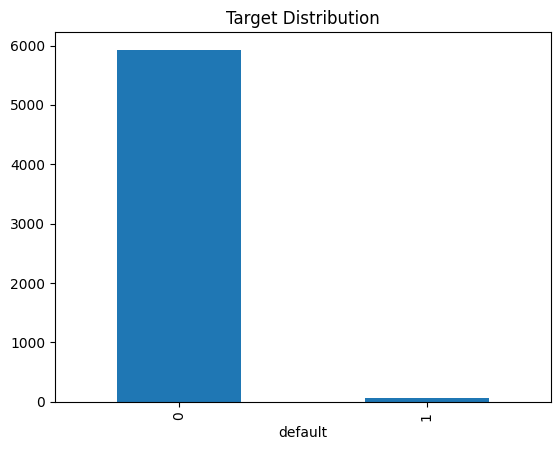

In [ ]:
df["default"].value_counts(normalize=True).plot(kind="bar", title="Target Distribution")

The `default` column is highly imbalanced:
- The majority of applicants (~98.8%) **did not default** (`default = 0`)
- Only a small minority (~1.2%) **did default** (`default = 1`)

## Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

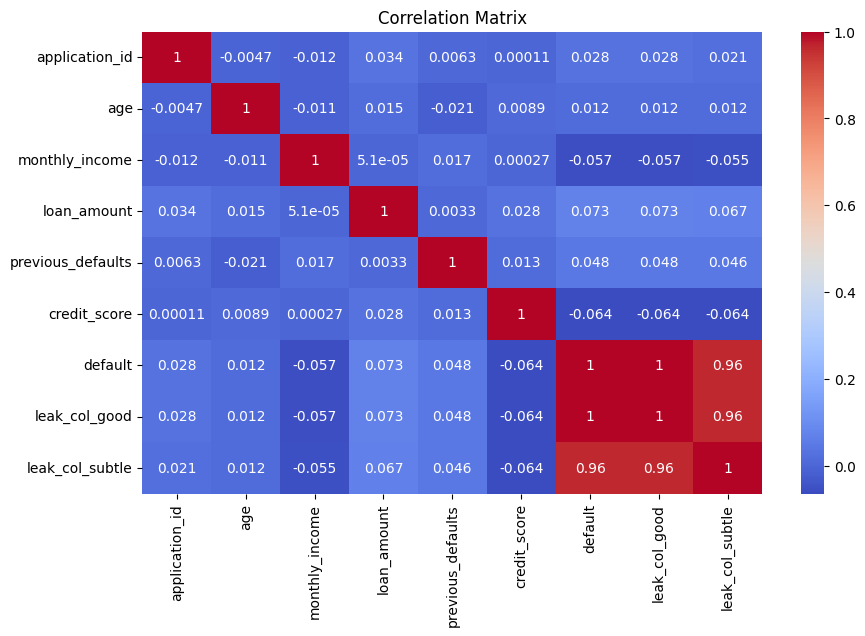

In [22]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")

### Correlation Matrix:

- Most features show **very low correlation** with the target `default` — typically under ±0.08, which is expected in real-world credit datasets.
- **`leak_col_good`** and **`leak_col_subtle`** show an **extremely high correlation** with `default` (≈ 0.96), which is **unrealistically high**.
- This confirms that these two columns are **leakage features** — meaning they contain information that wouldn't be available at prediction time.
- If included in the model, they would cause **artificially high performance** and lead to **data leakage**, making the model unusable in production.
- Therefore, both columns will be **dropped** before modeling to ensure fair and realistic evaluation.

In [23]:
df = df.drop(columns=["leak_col_good", "leak_col_subtle"])

## Features Distribution

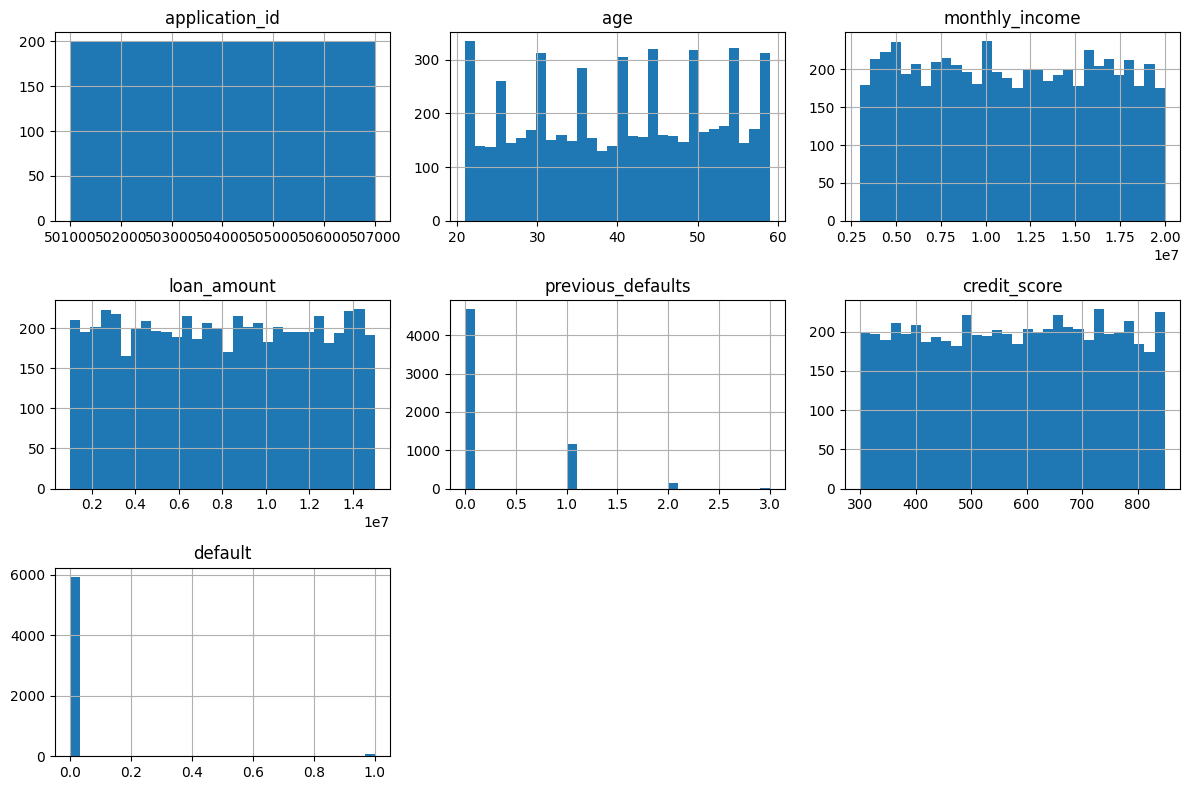

In [24]:
df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()

### Feature Distribution

- **`application_id`** is uniformly distributed — it is purely an identifier and will be excluded from modeling.
- **`age`** is well-distributed between 21 and 59 years, with no visible skew.
- **`monthly_income`** and **`loan_amount`** are spread widely and appear fairly uniform, but their large scale suggests they may benefit from log transformation for model stability.
- **`previous_defaults`** is highly right-skewed — the majority of applicants have **zero prior defaults**, while a few have 1 to 3.
- **`credit_score`** is evenly distributed between 300 and 850, aligning with typical scoring systems and making it a strong candidate for modeling.
- **`default`** again confirms class imbalance — only a small number of applicants actually defaulted.

Overall, feature distributions appear clean and ready for preprocessing, with a few features flagged for possible scaling or transformation.


In [25]:
df = df.drop(columns=["application_id"])

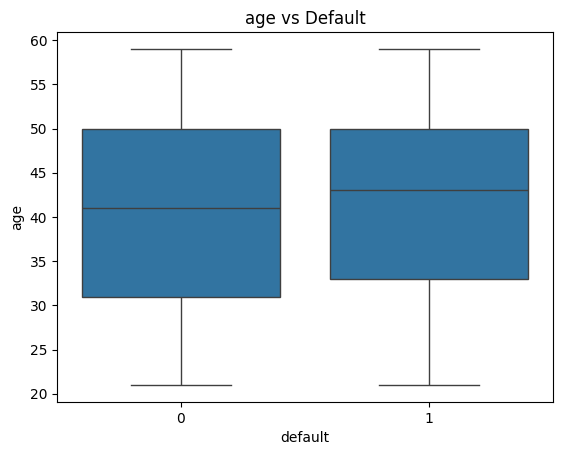

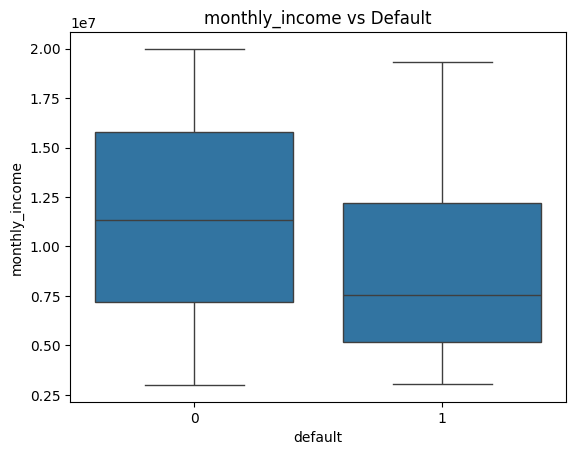

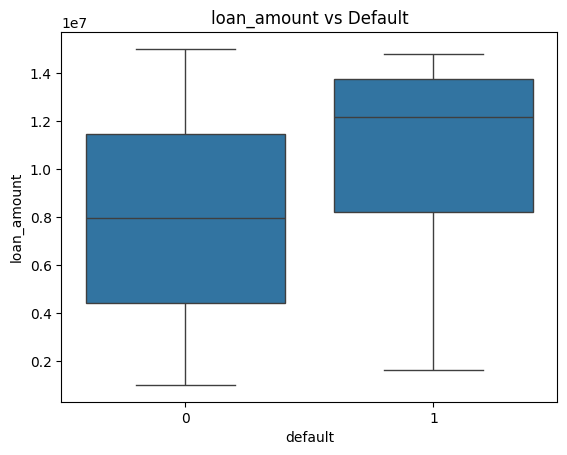

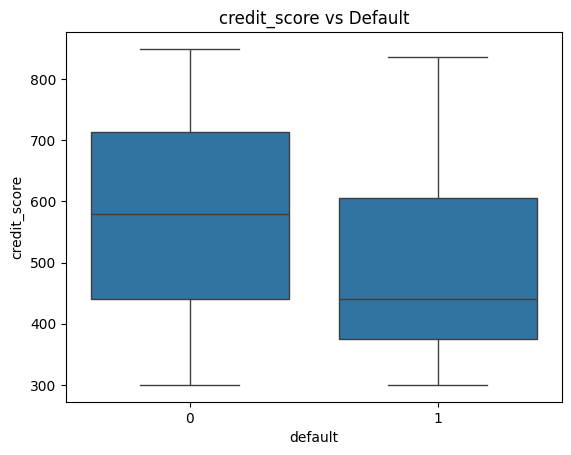

In [26]:
for col in ["age", "monthly_income", "loan_amount", "credit_score"]:
    sns.boxplot(data=df, x="default", y=col)
    plt.title(f"{col} vs Default")
    plt.show()

### Boxplot Analysis: Feature Distribution by Default Status

- **`age`**: There is no strong difference in age between defaulters and non-defaulters. Median age is slightly higher among those who defaulted, but not significantly.
- **`monthly_income`**: Defaulters tend to have **lower income** overall. The median monthly income is visibly lower compared to non-defaulters, which could indicate reduced ability to repay.
- **`loan_amount`**: Defaulters tend to have **larger loan amounts** on average. This may suggest that larger loans are riskier, especially for applicants with weaker financials.
- **`credit_score`**: This shows the most clear separation — applicants who defaulted have **consistently lower credit scores** than those who didn’t. This is a very strong signal and will likely be important in the model.

These plots reinforce that features like `credit_score`, `loan_amount`, and `monthly_income` carry meaningful predictive value for default risk.


EDA confirmed that the dataset is clean, balanced in most features, but highly imbalanced in the target. Key predictors like credit score and loan amount show strong signal with default. Leakage features were correctly identified and removed. The data is now ready for preprocessing and modeling.